### RFM Analysis
#### We'll perform RFM analysis on retail data and segment the customer based on recency, frequency and monetary value for Marketing department.
#### We'll use two methods for this analysis, the first method is Ranking and the second is using Clustering-K_Means.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retail-clean/retail_clean.csv


In [2]:
import matplotlib.pyplot as plt

### Ranking Method

In [3]:
retail=  pd.read_csv("../input/retail-clean/retail_clean.csv")

In [4]:
retail['InvoiceDate']= pd.to_datetime(retail['InvoiceDate'])

In [5]:
retail['date']= retail['InvoiceDate'].dt.strftime("%Y-%m-%d")

In [6]:
retail['date'] = pd.to_datetime(retail['date'])

### CALCULATING RECENCY

In [7]:
max_date=  retail['date'].max()

In [8]:
cust_recency = retail.groupby("Customer ID").agg(last_date = ("date",max)).reset_index()

In [9]:
## Customers with last purchase date
cust_recency

,Customer ID,last_date
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02
...,...,...
5937,18283.0,2011-12-06
5938,18284.0,2010-10-06
5939,18285.0,2010-02-17
5940,18286.0,2010-08-20


In [10]:
cust_recency['recency']= max_date - cust_recency['last_date']

In [11]:
cust_recency

,Customer ID,last_date,recency
0,12346.0,2011-01-18,325 days
1,12347.0,2011-12-07,2 days
2,12348.0,2011-09-25,75 days
3,12349.0,2011-11-21,18 days
4,12350.0,2011-02-02,310 days
...,...,...,...
5937,18283.0,2011-12-06,3 days
5938,18284.0,2010-10-06,429 days
5939,18285.0,2010-02-17,660 days
5940,18286.0,2010-08-20,476 days


In [12]:
cust_recency['recency']= cust_recency['recency'].astype("string").str.replace('days','').astype(int)

In [13]:
cust_recency.head()

,Customer ID,last_date,recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


### CALCULATING FREQUENCY

In [14]:
freq1 = retail.groupby(['Customer ID','Invoice']).agg(count= ("Description","count")).reset_index()

In [15]:
freq = freq1.groupby("Customer ID").agg(frequency = ("count","count")).reset_index()

In [16]:
freq.head()

,Customer ID,frequency
0,12346.0,17
1,12347.0,8
2,12348.0,5
3,12349.0,5
4,12350.0,1


### CALCULATING MONETARY VALUE

In [17]:
retail.columns

Index(['Unnamed: 0', 'Invoice', 'StockCode', 'Description', 'Quantity',
       'InvoiceDate', 'Price', 'Customer ID', 'Country', 'date'],
      dtype='object')

In [18]:
retail["Revenue"]= retail["Quantity"]* retail["Price"]

In [19]:
monet1= retail.groupby(["Customer ID","Invoice"]).agg(revenue =("Revenue","sum")).reset_index()

In [20]:
monet1.head()

,Customer ID,Invoice,revenue
0,12346.0,491725,45.0
1,12346.0,491742,22.5
2,12346.0,491744,22.5
3,12346.0,492718,22.5
4,12346.0,492722,1.0


In [21]:
monet = monet1.groupby("Customer ID").agg(monetary =("revenue","mean")).reset_index()

### RANKING, percentile based
#### For recency, less the better 
#### For frequency, more the better
#### For monetary, more the better

In [22]:
cust_recency['rank_recency']= cust_recency['recency'].rank(pct=True)

In [23]:
freq['rank_freq']= freq['frequency'].rank(ascending=False,pct=True)

In [24]:
monet['rank_monet']= monet['monetary'].rank(ascending=False,pct=True)

### Joining All Data

In [25]:
all_data = pd.merge(cust_recency,freq, how="left", on="Customer ID")

In [26]:
all_data = pd.merge(all_data,monet, how="left", on="Customer ID")

In [27]:
all_data.head()

,Customer ID,last_date,recency,rank_recency,frequency,rank_freq,monetary,rank_monet
0,12346.0,2011-01-18,325,0.707506,17,0.096264,-3.043529,0.987041
1,12347.0,2011-12-07,2,0.033995,8,0.250589,615.191250,0.068832
2,12348.0,2011-09-25,75,0.459525,5,0.388337,403.880000,0.185291
3,12349.0,2011-11-21,18,0.201195,5,0.388337,880.908000,0.030966
4,12350.0,2011-02-02,310,0.695894,1,0.877146,334.400000,0.273982


### CUSTOMER SEGMENTATION

In [28]:
bins =[0,0.5,1]

names = ['1','2']  ## groups

In [29]:
final = pd.DataFrame(cust_recency["Customer ID"])

In [30]:
final['frequency']= pd.cut(freq['rank_freq'], bins, labels=names).astype("string")

In [31]:
final['recency']= pd.cut(cust_recency['rank_recency'], bins, labels=names).astype("string")

In [32]:
final['monetary']= pd.cut(monet['rank_monet'], bins, labels=names).astype("string")

In [33]:
final.head()

,Customer ID,frequency,recency,monetary
0,12346.0,1,2,2
1,12347.0,1,1,1
2,12348.0,1,1,1
3,12349.0,1,1,1
4,12350.0,2,2,1


In [34]:
final['rec_freq_monet'] = final['recency']+final['frequency']+final['monetary']

In [35]:
final.head()

,Customer ID,frequency,recency,monetary,rec_freq_monet
0,12346.0,1,2,2,212
1,12347.0,1,1,1,111
2,12348.0,1,1,1,111
3,12349.0,1,1,1,111
4,12350.0,2,2,1,221


In [36]:
all_data['RFM'] = final['rec_freq_monet']

In [37]:
all_data.head()

,Customer ID,last_date,recency,rank_recency,frequency,rank_freq,monetary,rank_monet,RFM
0,12346.0,2011-01-18,325,0.707506,17,0.096264,-3.043529,0.987041,212
1,12347.0,2011-12-07,2,0.033995,8,0.250589,615.191250,0.068832,111
2,12348.0,2011-09-25,75,0.459525,5,0.388337,403.880000,0.185291,111
3,12349.0,2011-11-21,18,0.201195,5,0.388337,880.908000,0.030966,111
4,12350.0,2011-02-02,310,0.695894,1,0.877146,334.400000,0.273982,221


In [38]:
import seaborn as sns

[Text(0, 0, '212'),
 Text(1, 0, '111'),
 Text(2, 0, '221'),
 Text(3, 0, '112'),
 Text(4, 0, '222'),
 Text(5, 0, '121'),
 Text(6, 0, '122'),
 Text(7, 0, '211')]

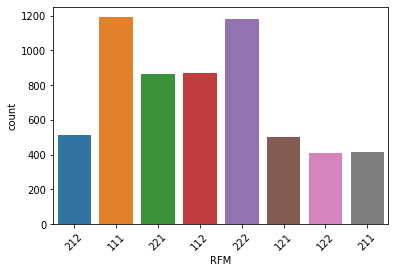

In [39]:
fig = sns.countplot(x= 'RFM', data= all_data)
fig.set_xticklabels(fig.get_xticklabels(), rotation= 45)

#### Conclusion : Marketing department can now startegize based on the customer groups, for eg 111 & 112 are loyal and can be offered some gifts, however 222 & 221 are lost cause as they don't buy frequently and its a long time since they shopped and they shop for low value.
#### for 212, though they buy frequently but its been a long time since they bough anything and therefore they can be targetted with some strategy.

### K-Means Clustering

In [40]:
all_data.columns

Index(['Customer ID', 'last_date', 'recency', 'rank_recency', 'frequency',
       'rank_freq', 'monetary', 'rank_monet', 'RFM'],
      dtype='object')

In [41]:
from sklearn.cluster import KMeans

In [42]:
X= all_data[['recency','frequency','monetary']]

In [43]:
km = KMeans(n_clusters= 3, n_init= 10, max_iter= 300, tol= 0.0001)

In [44]:
fitting = km.fit_predict(X)

In [45]:
### Centroids
fitting

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [46]:
X['centroids']=fitting

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
X.head

<bound method NDFrame.head of       recency  frequency    monetary  centroids
0         325         17   -3.043529          0
1           2          8  615.191250          0
2          75          5  403.880000          0
3          18          5  880.908000          0
4         310          1  334.400000          0
...       ...        ...         ...        ...
5937        3         22  121.131818          0
5938      429          2  218.340000          0
5939      660          1  427.000000          0
5940      476          3  396.143333          0
5941       42          8  522.236250          0

[5942 rows x 4 columns]>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


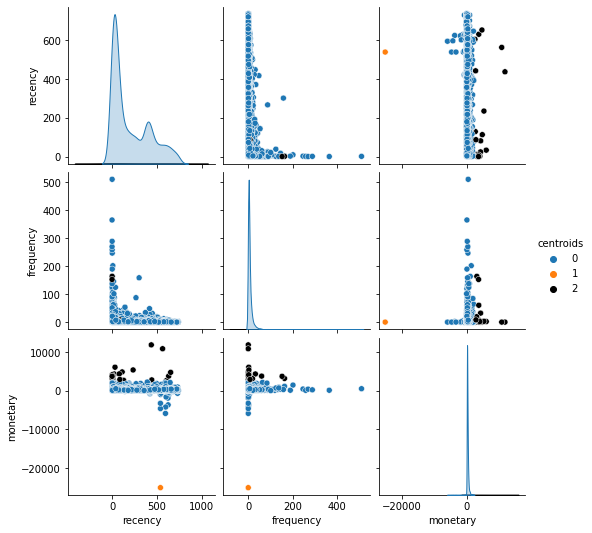

In [48]:
sns.pairplot(data=X, hue='centroids', palette=["C0", "C1", "k"])

### Elbow Spree to get the optimum K or number of clusters

In [49]:
### Sum of squared errors

sse =[]

for k in range(1,11):
    kmeans= KMeans(n_clusters= k, n_init= 10, max_iter= 300, tol= 0.0001)
    a= kmeans.fit(X)
    sse.append(a.inertia_)

In [50]:
sse

[1870448883.954063,
 1225123739.083827,
 855073277.1022171,
 626275774.3116075,
 450448448.2015297,
 348513644.9362592,
 255268464.10476506,
 199933007.65103477,
 170972613.96067354,
 145067055.86583978]

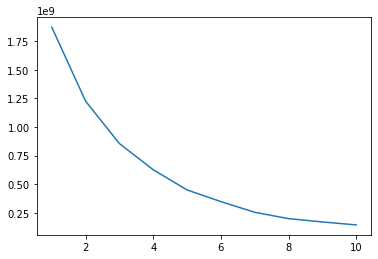

In [51]:
plt.plot(range(1,11),sse)

#### We can notice that the decline is gradual till 5 clusters and then it tends to smooth towards 10. Therefore, we can either go with 5 or 6 clusters.